In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1、导入数据

数据说明

·SeriousDlqin2yrs：违约客户及超过90天逾期客户，bool型；  
·RevolvingUtilizationOfUnsecuredLines：贷款以及信用卡可用额度与总额度比例，百分比；  
·age：用户年龄，整型  
·NumberOfTime30-59DaysPastDueNotWorse：35-59天逾期但不糟糕次数，整型；  
·DebtRatio：负债率，百分比；  
·MonthlyIncome：月收入，整型；  
·NumberOfOpenCreditLinesAndLoans：开放式信贷和贷款数量，开放式贷款（分期付款如汽车贷款或抵押贷款）和信贷（如信用卡）的数量，整型；  
·NumberOfTimes90DaysLate：90天逾期次数：借款者有90天或更高逾期的次数，整型；  
·NumberRealEstateLoansOrLines：不动产贷款或额度数量：抵押贷款和不动产放款包括房屋净值信贷额度，整型；  
·NumberOfTime60-89DaysPastDueNotWorse：60-89天逾期但不糟糕次数：借款人在在过去两年内有60-89天逾期还款但不糟糕的次数，整型；  
·NumberOfDependents：家属数量：不包括本人在内的家属数量，整型；

In [3]:
data_train = pd.read_csv('./data/cs-training.csv')

#变量重命名
columns = ({'SeriousDlqin2yrs':'target',
            'RevolvingUtilizationOfUnsecuredLines':'percentage',
            'NumberOfTime30-59DaysPastDueNotWorse':'30-59',
           'NumberOfOpenCreditLinesAndLoans':'open_loan',
           'NumberOfTimes90DaysLate':'90-',
           'NumberRealEstateLoansOrLines':'estate_loan',
           'NumberOfTime60-89DaysPastDueNotWorse':'60-89',
           'NumberOfDependents':'Dependents'
           }
          )
data_train.rename(columns=columns,inplace = True)

In [4]:
data_train.head()

,Unnamed: 0,target,percentage,age,30-59,DebtRatio,MonthlyIncome,open_loan,90-,estate_loan,60-89,Dependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
#删除id列
data_train.drop('Unnamed: 0',axis = 1 ,inplace = True)

#### 查看缺失值缺失值情况

In [6]:
miss_df = data_train.isnull().sum(axis=0).reset_index()
miss_df

,index,0
0,target,0
1,percentage,0
2,age,0
3,30-59,0
4,DebtRatio,0
5,MonthlyIncome,29731
6,open_loan,0
7,90-,0
8,estate_loan,0
9,60-89,0


可以看到MonthlyIncome和Dependents存在缺失值，下面针对这两个变量查看其缺失值所占比例

In [7]:
print(data_train['MonthlyIncome'].isnull().sum(axis=0)/data_train.shape[0])
print(data_train['Dependents'].isnull().sum(axis=0)/data_train.shape[0])

0.19820666666666667
0.02616


### 2、缺失值处理

对于缺失值处理，有很多种方法：

    缺失值极多：若缺失值样本占总数比例极高，直接舍弃，因为作为特征加入反而会引入噪声值（可以使用删除近零常量的方法删除）。
    非连续特征缺失值适中：如果缺值的样本适中，而该属性非连续值特征属性，就把NaN作为一个新类别，加入到类别特征中。
    连续特征缺失值适中：如果缺值的样本适中，考虑给定一个step，然后离散化，将NaN作为一个type加入到属性类目中。
    缺失值较少：考虑利用填充的办法进行处理。其中有均值、众数、中位数填充。
            用sklearn里的RandomForest/KNN模型去拟合数据样本训练模型，然后去填充缺失值。
            拉格朗日插值法。

由于MonthlyIncome的确实比例较大，这里采用随机森林模型去填充缺失值。

    具体做法如下，根据data_train中MonthlyIncome是否缺失，将整个数据集划分为训练集和测试集，其中MonthlyIncome未标签（y），MonthlyIncome缺失的部分作为测试数据集，将MonthlyIncome不缺失的data_train数据作为训练数据集，并利用训练数据集训练模型，之后利用模型预测对测试集进行预测。
    
Dependents变量缺失值比较少，直接删除，对总体模型不会造成太大影响。

In [8]:
from sklearn.ensemble import RandomForestRegressor

def rfr_fillna(df):
    #注意，此处不能将Dependents数据也作为训练数据，因为该特征存在缺失值
    miss_data = df.iloc[:,[5,0,1,2,3,4,6,7,8,9]]  #注意此处iloc和loc的区别，loc根据index来索引，而iloc是根据行号或列号来索引
    #根据MonthlyIncome是否缺失，将数据集划分为已知特征（训练集），和未知特征（测试集）
    know = miss_data[miss_data['MonthlyIncome'].notnull()].as_matrix()
    unknow = miss_data[miss_data['MonthlyIncome'].isnull()].as_matrix()
    #x,自变量（要训练的特征）
    x = know[:,1:]
    #y,因变量
    y = know[:,0]
    #n_estimators决策树个数，max_depth最大深度，n_jobs：并行job个数，1=不并行；n：n个并行；-1：CPU有多少core，就启动多少job
    rf_model = RandomForestRegressor(random_state=0,n_estimators=200,max_depth=3,n_jobs=-1)
    rf_model.fit(x,y)
    #预测缺失值
    pre_value = rf_model.predict(unknow[:,1:]).round(0)
    #填充缺失值
    df.loc[df['MonthlyIncome'].isnull(),'MonthlyIncome'] = pre_value
    return df

data_train = rfr_fillna(data_train)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
D:\anaconda\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [9]:
#Dependents变量缺失值比较少，直接删除，对总体模型不会造成太大影响。对缺失值处理完之后，删除重复项
data_train = data_train.dropna()
data_train = data_train.drop_duplicates()
data_train.info

<bound method DataFrame.info of         target  percentage  age  30-59    DebtRatio  MonthlyIncome  open_loan  \
0            1    0.766127   45      2     0.802982         9120.0         13   
1            0    0.957151   40      0     0.121876         2600.0          4   
2            0    0.658180   38      1     0.085113         3042.0          2   
3            0    0.233810   30      0     0.036050         3300.0          5   
4            0    0.907239   49      1     0.024926        63588.0          7   
5            0    0.213179   74      0     0.375607         3500.0          3   
6            0    0.305682   57      0  5710.000000         8311.0          8   
7            0    0.754464   39      0     0.209940         3500.0          8   
9            0    0.189169   57      0     0.606291        23684.0          9   
10           0    0.644226   30      0     0.309476         2500.0          5   
11           0    0.018798   51      0     0.531529         6501.0          7

### 3、离群值处理

离群值是指明显偏离大多数抽样数据的数值，比如个人客户的年龄大于100或小于0时，通常认为该值为异常值。找出样本总体中的异常值，通常采用离群值检测的方法。 离群值检测的方法有单变量离群值检测、局部离群值因子检测、基于聚类方法的离群值检测等方法。在本数据集中，采用单变量离群值检测来判断异常值，采用箱线图。

1、对于percentage和DebtRatio中大于1的数据直接删除（百分比）

2、通过箱型图发现30-59、60-89、90-，这三个特征均有离群值，查看离群值的数量发现，三个特征离群值数量相等，且都不多，直接删除离群值；

3、月收入也同样使用箱型图进行离群值判断

（注意，此处都是借助箱型图进行主观判断，其实应该借助四分位距进行判断才比较合理）

In [10]:
data_train.describe()

,target,percentage,age,30-59,DebtRatio,MonthlyIncome,open_loan,90-,estate_loan,60-89,Dependents
count,145563.000000,145563.000000,145563.000000,145563.000000,145563.000000,1.455630e+05,145563.000000,145563.000000,145563.000000,145563.000000,145563.000000
mean,0.067538,5.941378,52.110701,0.389185,334.548251,6.116310e+03,8.553788,0.231309,1.033346,0.205622,0.759863
std,0.250952,250.510835,14.567652,3.756944,1947.228209,1.318221e+04,5.141132,3.728803,1.133115,3.712455,1.116141
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.031218,41.000000,0.000000,0.173934,2.554000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.158817,52.000000,0.000000,0.359090,5.000000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.561085,62.000000,0.000000,0.770641,8.166000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,107.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [11]:
#对于percentage和DebtRatio中大于1的数据直接删除（百分比）
data_train = data_train[(data_train['DebtRatio'] < 1) & (data_train['percentage'] < 1)]

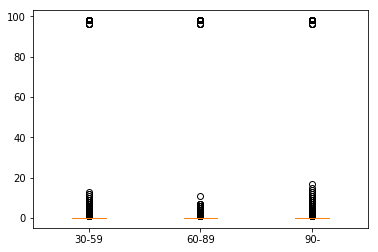

In [12]:
#查看
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.boxplot([data_train['30-59'],data_train['60-89'],data_train['90-']])
ax.set_xticklabels(['30-59','60-89','90-'])
plt.show()

In [13]:
data_train[data_train['30-59'] > 60].shape
data_train[data_train['60-89'] > 90].shape
data_train[data_train['90-'] > 90].shape

(185, 11)

In [14]:
data_train = data_train[data_train['30-59'] < 60]
data_train = data_train[data_train['60-89'] < 90]
data_train = data_train[data_train['90-'] < 90]
data_train.reset_index(drop=True,inplace=True) #重设索引

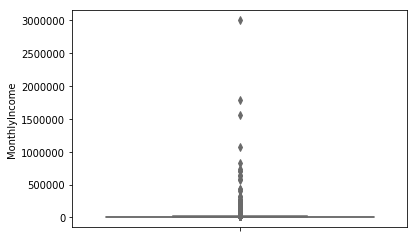

In [15]:
sns.boxplot(data_train.MonthlyIncome,palette = 'Set3',orient = 'v')
plt.show()
data_train[data_train['MonthlyIncome'] > 50000].shape
data_train = data_train[data_train['MonthlyIncome'] < 50000]
data_train = data_train.reset_index(drop=True)#重设索引

### 4、数据探索

在建立模型之前，我们一般会对现有的数据进行 探索性数据分析（Exploratory Data Analysis） 。 EDA是指对已有的数据(特别是调查或观察得来的原始数据)在尽量少的先验假定下进行探索。常用的探索性数据分析方法有：直方图、散点图和箱线图等。

单变量部分：

1、好坏顾客比例分布不平衡，坏顾客占比较低，因此考虑后期采用smote算法进行过采样处理；

2、客户年龄分布和月收入分布，都大致呈正态分布，符合统计分析的假设。

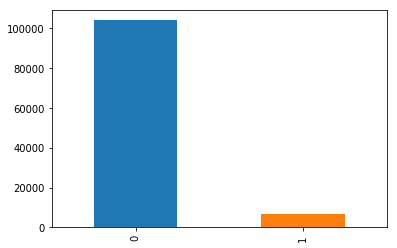

In [16]:
#首先计算好坏顾客比例
data_train.target.value_counts().plot(kind='bar')
plt.show()
t = data_train.target.value_counts()[1]/len(data_train)

可以看到坏顾客对应类别的样本比例较少，因此后面将考虑采用smote算法进行上采样

D:\anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
D:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


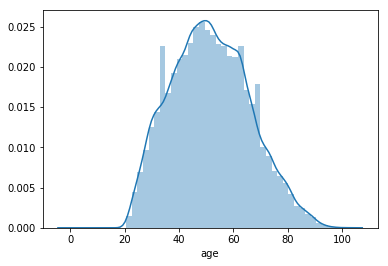

In [17]:
sns.distplot(data_train.age)  #基本符合正态分布
plt.show()

D:\anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
D:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


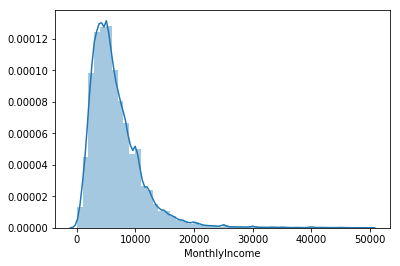

In [18]:
sns.distplot(data_train.MonthlyIncome)
plt.show()

多变量处理，查看变量之间的相关性，判断是否存在多重共线性；

通过变量间相关系数绘制的热力图可以看出，虽然变量之间存在一定的相关性，但是其相关系数都不大，因此不存在多重共线性。

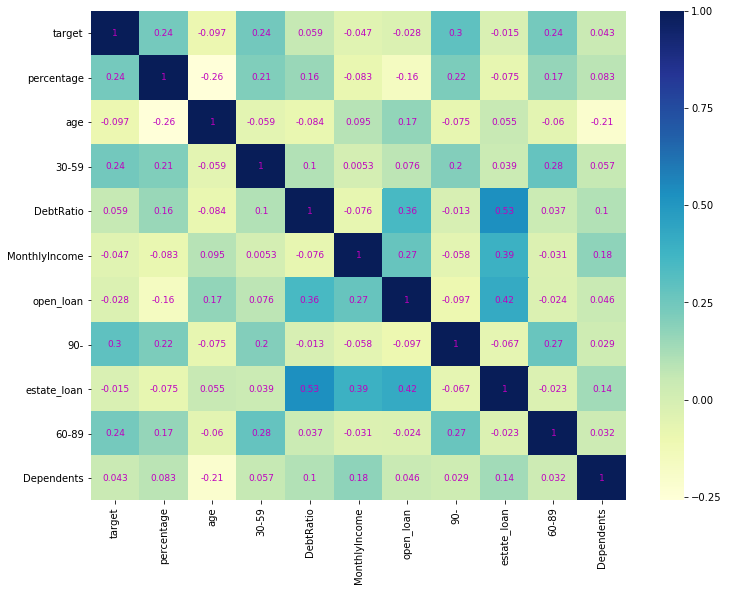

In [19]:
corr = data_train.corr()
fig = plt.figure(figsize=[12,9])
ax = fig.add_subplot(1,1,1)
sns.heatmap(corr,annot=True, cmap='YlGnBu', ax=ax, annot_kws={'size': 9, 'color': 'm'})#绘制相关性系数热力图
plt.show()

### 5、特征选择（woe）

我们采用信用评分模型的变量选择方法，通过WOE分析方法，即是通过比较指标分箱和对应分箱的违约概率来确定指标是否符合经济意义。

首先我们对变量进行离散化（分箱）处理。

    变量分箱（binning）是对连续变量离散化（discretization）的一种称呼。信用评分卡开发中一般有常用的等距分段、等深分段、最优分段。其中等距分组（Equval length intervals）是指分组的区间是一致的，比如年龄以十年作为一个分组；等深分组（Equal frequency intervals）是先确定分组数量，然后令每个分组中数据数量大致相等；最优分组（Optimal Binning）又叫监督离散化（supervised discretizaion），使用递归划分（Recursive Partitioning）将连续变量分为分组，背后是一种基于条件推断查找较佳分组的算法。
    
    WoE分析， 是对指标分箱、计算各个档位的WoE值并观察WoE值随指标变化的趋势。其中WoE的数学定义是:
    woe=ln(goodattribute/badattribute)
    在进行分析时，我们需要对各指标从小到大排列，并计算出相应分档的WoE值。其中正向指标越大，WoE值越小；反向指标越大，WoE值越大。正向指标的WoE值负斜率越大，反响指标的正斜率越大，则说明指标区分能力好。WoE值趋近于直线，则意味指标判断能力较弱。若正向指标和WoE正相关趋势、反向指标同WoE出现负相关趋势，则说明此指标不符合经济意义，则应当予以去除。

我们首先选择对连续变量进行最优分段，在连续变量的分布不满足最优分段的要求时，再考虑对连续变量进行等距分段。最优分箱的代码如下：

In [20]:
from scipy import stats
#如果n不为空则表示使用最优分组，如果n为None,且bin_不为None,则表示使用等距分组，此时要给出分组区间
def mono_bin(Y,X,n=None,bin_x=None):
    r = 0
    total_bad = Y.sum()
    total_good = Y.count() - Y.sum()
    if n: 
        while np.abs(r) < 1:
            d1 = pd.DataFrame({'Y':Y,'X':X,'Bucket':pd.qcut(X,n,duplicates='raise')}) #返回一个数据框，共三列，X,Y,所属分组区间
            d2 = d1.groupby('Bucket',as_index=True)   #as_index=True则聚合后（如添加.mean()）将Bucket列作为索引，为False则新生成索引
            r,p = stats.spearmanr(d2.mean().X,d2.mean().Y) #计算各区间X的均值与Y的均值的相关系数和对应的p值(注意返回的r和p都是一个数），如果r的绝对值大于或等于1，则循环结束
            n = n - 1
    else:
        d1 = pd.DataFrame({'Y':Y,'X':X,'Bucket':pd.cut(X,bin_x)}) #返回一个数据框，共三列，X,Y,所属分组区间
        d2 = d1.groupby('Bucket',as_index=True)   #as_index=True则聚合后（如添加.mean()）将Bucket列作为索引，为False则新生成索引
        r,p = stats.spearmanr(d2.mean().X,d2.mean().Y)
    d3 = pd.DataFrame(d2.min().X,columns=['min_' + X.name]) #注意这里d3只是个空的数据框，没有数据
    d3['min_' + X.name] = d2.min().X
    d3['max_' + X.name] = d2.max().X
    d3[Y.name] = d2.sum().Y
    d3['total'] =  d2.count().Y
    d3['bad_rate'] = d3[Y.name]/total_bad  #各组坏顾客占所有坏顾客的比例
    d3['good_rate'] = (d3['total'] - d3[Y.name])/total_good   #各组好顾客占所有好顾客的比例
    d3['woe'] = np.log(d3['good_rate'] / d3['bad_rate'])   #计算woe值
    iv = ((d3['good_rate'] - d3['bad_rate'])*d3['woe']).sum()  #根据woe值计算iv值
    d4 = (d3.sort_values(by='min_' + X.name)).reset_index(drop=True)   #根据最小值进行排序
    if n:
        #获取分组区间
        cut = []
        cut.append(float('-inf'))   #float(-inf)表示负无穷
        for i in range(1,n+1): #注意如果实际分为了3组,则n的实际值为2
            qua = X.quantile(i/(n+1))
            cut.append(round(qua,4))
        cut.append(float('inf'))  #正无穷
        woe = list(round(d4['woe'],2))
        return d4,iv,cut,woe       
    else:
        woe = list(round(d4['woe'],2))
        return d4,iv,woe

In [21]:
#注意x1表示第一个自变量
df_x1,iv_x1,cut_x1,woe_x1 = mono_bin(data_train['target'],data_train['percentage'],n=10)
df_x2,iv_x2,cut_x2,woe_x2 = mono_bin(data_train['target'],data_train['age'],n=10)
#df_x4,iv_x4,cut_x4,woe_x4 = mono_bin(data_train['target'],data_train['DebtRatio'],n=10)
df_x5,iv_x5,cut_x5,woe_x5 = mono_bin(data_train['target'],data_train['MonthlyIncome'],n=10)

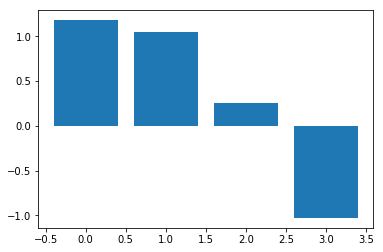

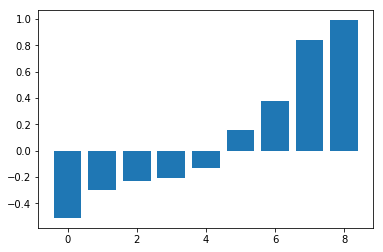

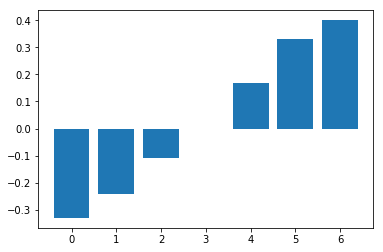

In [22]:
#根据柱状图查看分箱效果，分箱后，越单调效果越好
plt.bar(range(len(woe_x1)),woe_x1)
plt.show()

plt.bar(range(len(woe_x2)),woe_x2)#完全单调，分箱效果不错
plt.show()

plt.bar(range(len(woe_x5)),woe_x5)
plt.show()

In [23]:
#其余变量离散化
pinf = float('inf')  #正无穷
ninf = float('-inf') #负无穷
cut_x3 = [ninf, 0, 1, 3, 5, pinf]
cut_x4 = [ninf,0,0.1,0.35,pinf]
cut_x6 = [ninf, 1, 2, 3, 5, pinf]
cut_x7 = [ninf, 0, 1, 3, 5, pinf]
cut_x8 = [ninf, 0,1,2, 3, pinf]
cut_x9 = [ninf, 0, 1, 3, pinf]
cut_x10 = [ninf, 0, 1, 2, 3, 5, pinf]

df_x3,iv_x3,woe_x3 = mono_bin(data_train['target'],data_train['30-59'],bin_x=cut_x3)
df_x4,iv_x4,woe_x4 = mono_bin(data_train['target'],data_train['DebtRatio'],bin_x=cut_x4)
df_x6,iv_x6,woe_x6 = mono_bin(data_train['target'],data_train['open_loan'],bin_x=cut_x6)
df_x7,iv_x7,woe_x7 = mono_bin(data_train['target'],data_train['90-'],bin_x=cut_x7)
df_x8,iv_x8,woe_x8 = mono_bin(data_train['target'],data_train['estate_loan'],bin_x=cut_x8)
df_x9,iv_x9,woe_x9 = mono_bin(data_train['target'],data_train['60-89'],bin_x=cut_x9)
df_x10,iv_x10,woe_x10 = mono_bin(data_train['target'],data_train['Dependents'],bin_x=cut_x10)

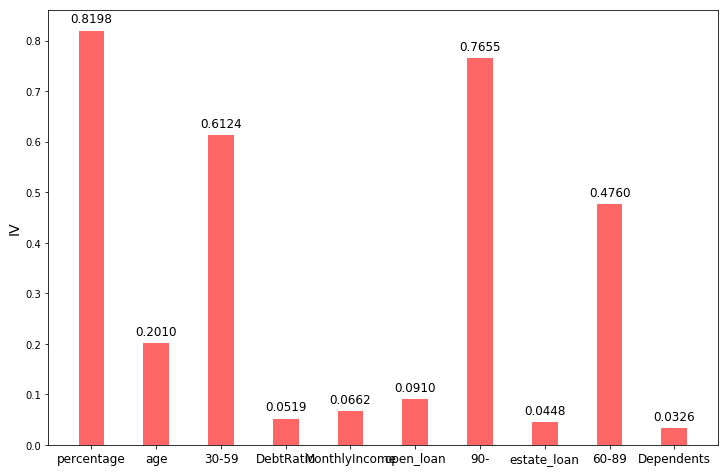

In [24]:
#绘制根据各变量的iv值绘制柱状图
y = [iv_x1,iv_x2,iv_x3,iv_x4,iv_x5,iv_x6,iv_x7,iv_x8,iv_x9,iv_x10]
index = data_train.columns.drop('target')
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(1,1,1)
ax.bar(range(1,11),y,width=0.4,color = 'r',alpha = 0.6)
ax.set_xticks(range(1,11))
ax.set_xticklabels(index, fontdict={'fontsize':12,'rotation':0 })
ax.set_ylabel('IV',fontdict={'fontsize':14})
#在每个柱状图上添加数值标签
for i,v in enumerate(y):
    plt.text(i+1, v+0.01, '%.4f' %v, ha='center', va='bottom', fontsize = 12)
plt.show()

对IV值的理解：

    从直观逻辑上大体可以这样理解“用IV去衡量变量预测能力”这件事情：我们假设在一个分类问题中，目标变量的类别有两类：Y1，Y2。对于一个待预测的个体A，要判断A属于Y1还是Y2，我们是需要一定的信息的，假设这个信息总量是I，而这些所需要的信息，就蕴含在所有的自变量C1，C2，C3，……，Cn中，那么，对于其中的一个变量Ci来说，其蕴含的信息越多，那么它对于判断A属于Y1还是Y2的贡献就越大，Ci的信息价值就越大，Ci的IV就越大，它就越应该进入到入模变量列表中。

根据IV值判断变量预测能力的标准:  

    < 0.02： useless for predition  
    0.02-0.1： weak predictor  
    0.1-0.3： medium predictor  
    0.3-0.5： strong predictor  
    大于0.5： suspicious or too good to be true  

删除掉iv小于0.1的变量，DebtRatio,MonthlyIncome,open_loan,estate_loan,Dependents

In [25]:
#将data_train中的每个变量的每个值根据其所属的分组，转换为该组对应的woe值
def change_woe(d,cut,woe):
    list_ = []
    i = 0
    while i < len(d):
        value = d[i]
        j = len(cut) - 2
        m = len(cut) - 2
        while j > 0:
            if value >= cut[j]:
                j = -1
            else:
                j -= 1
                m -= 1
        list_.append(woe[m])
        i += 1
    return list_

In [26]:
data_train['percentage'] = pd.Series(change_woe(data_train['percentage'],cut_x1,woe_x1))
data_train['age'] = pd.Series(change_woe(data_train['age'], cut_x2, woe_x2))
data_train['30-59'] = pd.Series(change_woe(data_train['30-59'], cut_x3, woe_x3))
data_train['DebtRatio'] = pd.Series(change_woe(data_train['DebtRatio'], cut_x4, woe_x4))
data_train['MonthlyIncome'] = pd.Series(change_woe(data_train['MonthlyIncome'], cut_x5, woe_x5))
data_train['open_loan'] = pd.Series(change_woe(data_train['open_loan'], cut_x6, woe_x6))
data_train['90-'] = pd.Series(change_woe(data_train['90-'], cut_x7, woe_x7))
data_train['estate_loan'] = pd.Series(change_woe(data_train['estate_loan'], cut_x8, woe_x8))
data_train['60-89'] = pd.Series(change_woe(data_train['60-89'], cut_x9, woe_x9))
data_train['Dependents'] = pd.Series(change_woe(data_train['Dependents'], cut_x10, woe_x10))

In [27]:
#删除iv值较小的变量
train_data_x = data_train.drop(columns=['DebtRatio','MonthlyIncome','open_loan','estate_loan','Dependents'],axis = 1)

### 6、模型建立

借助sklearn库建立logistic模型

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

x = train_data_x.drop(columns=['target'],axis = 1)
y = train_data_x['target']

In [29]:
#由于数据正负样本比例不平衡，所以此处对数据集进行smote过采样
from imblearn.over_sampling import SMOTE

#默认生成正负样本比例为1：1，可通过radio参数指定对应类别要生成的数据的数量smo = SMOTE(ratio={1: 300 },random_state=42)
smo = SMOTE(random_state=42) 
x_smo, y_smo = smo.fit_sample(x, y)

In [30]:
#划分数据集
train_x,test_x,train_y,test_y = train_test_split(x_smo,y_smo,test_size = 0.3, random_state = 0)
lr = LogisticRegression(penalty='l1')
lr.fit(train_x,train_y)

D:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

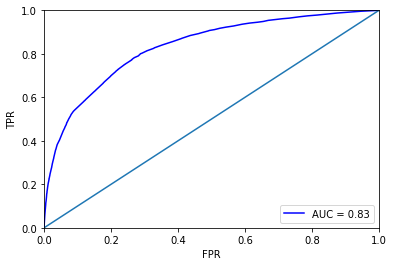

In [31]:
#绘制roc和AUC曲线
from sklearn.metrics import roc_curve,auc

##lr.predict_proba(train_x)返回两列数据，第一列为target属于0的概率，第二列为target属于1的概率，这里获取target属于1的概率
train_predprob = lr.predict_proba(train_x)[:,1] 
test_predprob = lr.predict_proba(test_x)[:,1]
#TPR = TP / (TP+FN)表示当前分到正样本中真实的正样本所占所有正样本的比例，也就是召回率；
#FPR = FP / (FP + TN)表示当前被错误分到正样本类别中真实的负样本所占所有负样本总数的比例；
FPR,TPR,threshold = roc_curve(test_y,test_predprob)
ROC_AUC = auc(FPR,TPR)
plt.plot(FPR,TPR,'b',label='AUC = %0.2f' % ROC_AUC)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'-')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

### 7、信用评分

一个事件发生的概率为odds,如果一个客户违约的概率为p，则：odds=p/(1-p)  
此时客户违约的概率p可以表示成：p=odds / (1+odds)  
评分表达式可以表示成：scores=A + B * log(odds)  
其中A、B为常数，由于log函数在(0→+∞)单调递增，所以当用户违约几率Odds越大时，Score评分越低。  
通过给定：  
    （1）某特定Odds时的Score值S0；   
    （2）该特定Odds值翻倍时Score增加值PD0;   
通过给定值S0与PD0带入评分卡表达式，可求得A、B。   
    通过以上分析，求该用户评分Score的问题则转化为求用户违约对数几率log(Odds)= a0 + b1*x1 + b2*x2 + ... + bn*xn 的问题。 （具体过程可以参考这篇文章https://blog.csdn.net/htbeker/article/details/79697557 ) 
    
    scores = A - B * (a0 + b1*x1 + b2*x2 + ... + b5*x5) ;  x = woe ，a0为常数项，b为系数  
         = (A - B * a0) + B*b1*woe_x1 + ... 
         = 基础得分 + 各变量得分  
在建立标准评分卡之前，我们需要选取几个评分卡参数：基础分值（不是上述公式中的基础的分）、 PDO（比率翻倍的分值）和好坏比。 这里， 我们取600分为基础分值，PDO为20 （每高20分好坏比翻一倍），好坏比取20。

In [32]:
import math

B = 20 / math.log(2)
A = 600 - B / math.log(20)
base_score = round(A + B * lr.intercept_[0],0)

def compute_score(coe,woe_list,B):
    '''
    计算变量中各个分组对应的分数。
    注意：之前对各变量的数据进行了woe值变换，比如对于变量percentage，其数据已经变换成woe值，其woe值主要有4个唯一值，对应4个组（woe_x1 = [1.18, 1.05, 0.25, -1.03]），
        因此，只需要计算出这4个分组的分数，再根据其所属分组进行匹配响应的分数即可，变量percentage分数为：x1_percentage=[-22.0, -20.0, -5.0, 19.0]
    '''
    score_list=[]
    for woe in woe_list:
        score = round(B * coe * woe , 0)
        score_list.append(score)
    return score_list

#各变量woe值对应的分数
x1_percentage = compute_score(lr.coef_[0][0], woe_x1, B)
x2_age = compute_score(lr.coef_[0][1], woe_x2, B)
x4_59 = compute_score(lr.coef_[0][2], woe_x4, B)
x7_90 = compute_score(lr.coef_[0][3], woe_x7, B)
x9_60 = compute_score(lr.coef_[0][4], woe_x9, B)

D:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
D:\anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


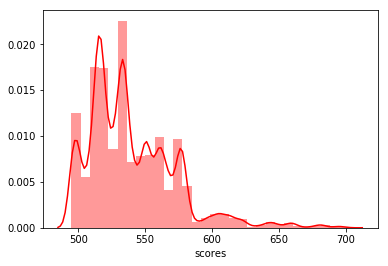

<Figure size 1008x504 with 0 Axes>

In [33]:
def change_score(series,cut,score):
    '''
    与woe转换同理，只是下面17行处的woe换成了score
    '''
    list_ = []
    i = 0
    while i < len(series):
        value = series[i]
        j = len(cut) - 2
        m = len(cut) - 2
        while j >= 0:
            if value >= cut[j]:
                j = -1
            else:
                j -= 1
                m -= 1
        list_.append(score[m])
        i += 1
    return list_

#导入test数据
test1 = pd.read_csv( './data/cs-test.csv')
test2 = pd.DataFrame()
test1.rename(columns=columns,inplace = True)
#此处直接用训练集训练好的各变量的分组，匹配各组对应的分数即可(如：cut_x1=[-inf, 0.0321, 0.1609, 0.5313, inf],分组里面的数据仍是原始data_train数据)
test2['x1_percentage'] = pd.Series(change_score(test1['percentage'], cut_x1, x1_percentage))
test2['x2_age'] = pd.Series(change_score(test1['age'], cut_x2, x2_age))
test2['x4_59'] = pd.Series(change_score(test1['DebtRatio'], cut_x4,x4_59))
test2['x7_90'] = pd.Series(change_score(test1['90-'], cut_x7, x7_90))
test2['x9_60'] = pd.Series(change_score(test1['60-89'], cut_x9, x9_60))
#分数加总
test2['scores'] =base_score + test2['x1_percentage'] + test2['x2_age'] + test2['x4_59']+test2['x7_90']+test2['x9_60']
#查看评分分布
sns.distplot(test2['scores'],bins = 30,color = 'r')
plt.figure(figsize=(14,7))
plt.show()